# UDACITY SELF DRIVING CAR NANODEGREE


## P3 - Behavioral Cloning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.optimizers import Adam, RMSprop
from keras.layers.core import Dense, Activation
from keras.layers import Input, Convolution2D, MaxPooling2D, Flatten, PReLU, Dropout
from keras.models import Sequential, Model
from keras import backend as K
from keras.regularizers import l2
import os.path
import csv
import cv2
import glob
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import json
from keras import callbacks
SEED = 42
%matplotlib inline

Using TensorFlow backend.


## DATA EXPLORATION
------------------------

* all images are stored in **data/IMG/** 


* log.csv contains the list of image filenames and the corresponding parameter values:

 *center_camera*, *left_camera*, *right_camera*, *steering_angle*, *throttle*, *brake*, *speed*

In [2]:
data_path = 'data/'

# open csv file
with open(data_path + 'driving_log.csv', 'r') as csvfile:
    file_reader = csv.reader(csvfile, delimiter=',')
    log = []
    for row in file_reader:
        log.append(row)

log = np.array( log )
log = log[1:,:] #remove the header

#account for left/right/center
print('Dataset: \n {} images | Number of steering data: {}'.format(len(log) * 3, len(log)) ) 

# Sanity check: list all image files in data/IMG
ls_imgs = glob.glob(data_path+ 'IMG/*.jpg')
assert len(ls_imgs) == len(log)*3, 'Actual number of *jpg images does not match with the csv log file'

Dataset: 
 24108 images | Number of steering data: 8036


### Image Visualization

The images are RGB format.

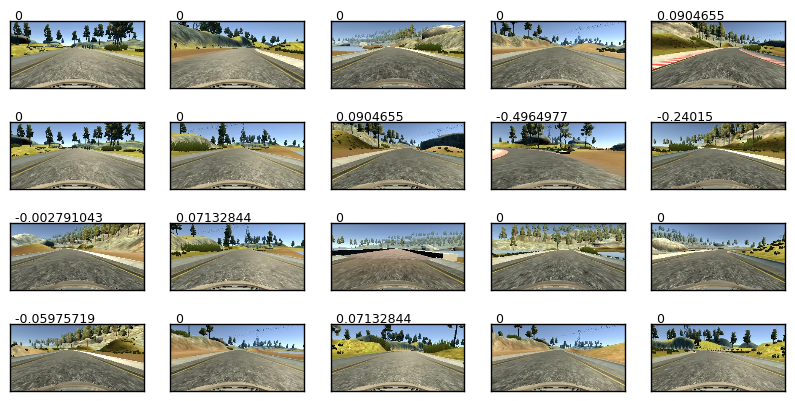

In [3]:
n_imgs = 20
steering_col = 3
ls_imgs = np.random.choice(np.arange(len(log)), size = n_imgs, replace=False)

_, ax = plt.subplots( 4, 5, figsize=(10, 5))
col, row = 0, 0
print(  )
for i in ls_imgs: 
    img = cv2.imread(data_path+ log[i, 0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[row, col].imshow(img)
    ax[row, col].text(3, -5, log[i, steering_col], fontsize=9)
    ax[row, col].get_xaxis().set_ticks([])
    ax[row, col].get_yaxis().set_ticks([])

    if col == 4:
        row, col = row+1, 0
    else:
        col += 1

plt.show()

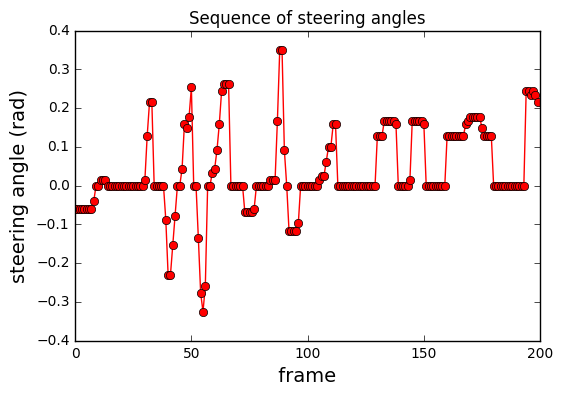

In [4]:
plt.plot(np.arange(200), log[100:300, 3].astype(float), 'r-o')
plt.xlabel(' frame ', fontsize=14)
plt.ylabel('steering angle (rad)', fontsize=14)
plt.title('Sequence of steering angles')
plt.show()

### Data Exploration

* Steering angle of value 0 have the highest occurence: more than 10 times the occurence of other angle values.

* There are more positive angle values than negative angle values.

Number of unique angles value (10^-2 precision): 124


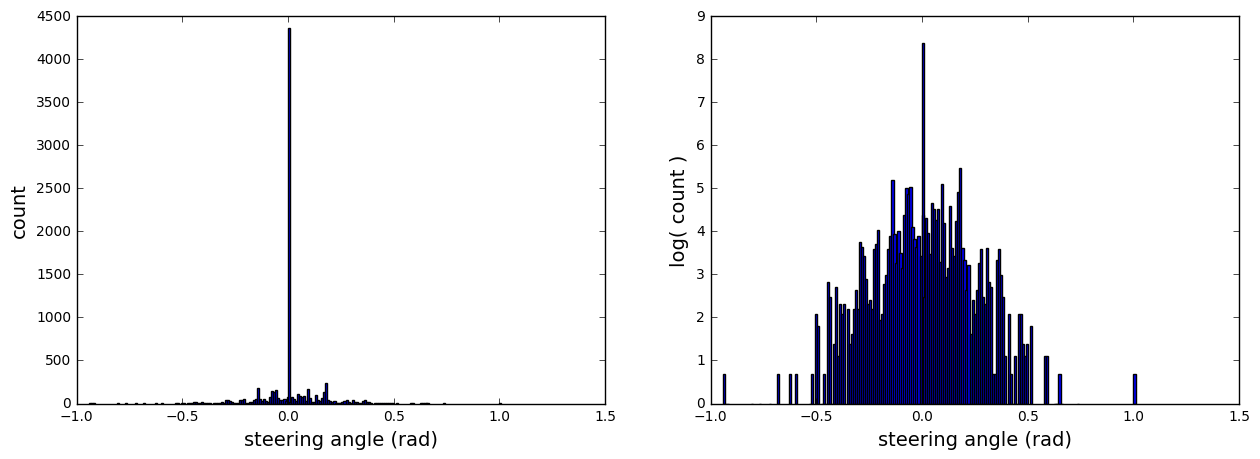

Count of positive angles: 1900 | Negative angles: 1775


In [5]:
# Set angle value precision to 10^-2
precision = 0.0001
steering_angle = log[:, 3].astype(float) * 1/precision #convert steering to degrees
steering_angle = steering_angle.astype(int) * precision

unique_st_angles = np.unique(steering_angle)
# get unique values
print('Number of unique angles value (10^-2 precision): {}'.format( len(unique_st_angles)) )

# Histogram of steering angle values
hist = []
for i in unique_st_angles :
    count = np.sum( steering_angle == i )
    hist.append([i, count])

hist = np.array(hist)
#plot histogram
_, ax = plt.subplots( 1, 2, figsize=(15, 5) )
ax[0].bar(hist[:,0], hist[:,1], width=0.01, color='b')
ax[0].set_xlabel('steering angle (rad)', fontsize=14)
ax[0].set_ylabel('count', fontsize=14)


ax[1].bar(hist[:,0], np.log( hist[:,1] ), width=0.01, color='b')
plt.xlabel('steering angle (rad)', fontsize=14)
plt.ylabel('log( count )', fontsize=14)

plt.show()

cnt_neg = np.sum(steering_angle < 0)
cnt_pos = np.sum(steering_angle > 0)
print('Count of positive angles: {} | Negative angles: {}'.format(cnt_pos, cnt_neg))

# DATA AUGMENTATION


## Horizontal flip:

After the image is flipped horizontally, the sign of the steering angle is changed: 

($\theta_{\text{flip}} = -\theta$)


## Cross-track error: 
We use the images from the Left and Right camera and adjust the steering angle value with a constant angle shift: 

$$\Delta \theta = \pm 1/4$$. 

The idea is to artificially generate a cross-track error by using a different view point.

![GitHub Logo](../figs_readme/left_camera.png)

$$ tan(s ') = tan( s ) + \frac{\Delta x}{h} $$

In the limit of small angles:

left camera : $$ s ' =  s  + \frac{\Delta x}{h} $$

right camera :  $$ s ' =  s  - \frac{\Delta x}{h} $$


## Image brightness

First, the images are converted from RGB to HSV format, and the Value component is varied by a random factor between 0.1 and 1.0, i.e:

$$V_{new} = \alpha \times V$$

### 1. HORIZONTAL FLIP OF THE IMAGES

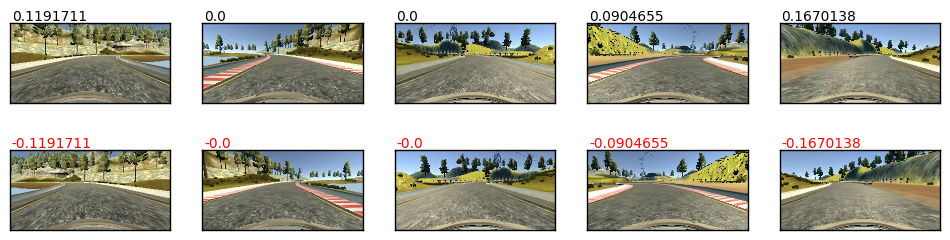

In [6]:
n_imgs = 5
ls_imgs = np.random.choice(np.arange(len(log)), size = n_imgs, replace=False)

_, ax = plt.subplots( 2, n_imgs, figsize=(12, 3))
col, row = 0, 0

for i in ls_imgs: 
    img = cv2.imread(data_path+ log[i, 0])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax[row, col].imshow(img)
    ax[row, col].text(3, -5, float(log[i,3]), fontsize=10, color='black')
    ax[row, col].get_xaxis().set_ticks([])
    ax[row, col].get_yaxis().set_ticks([])

    ax[row+1, col].imshow(cv2.flip(img, 1))
    ax[row+1, col].text(3, -5,  -float(log[i, 3]), fontsize=10, color='red')
    ax[row+1, col].get_xaxis().set_ticks([])
    ax[row+1, col].get_yaxis().set_ticks([])
    
    col = col + 1
plt.show()

### 2. CROSS-TRACK ERROR

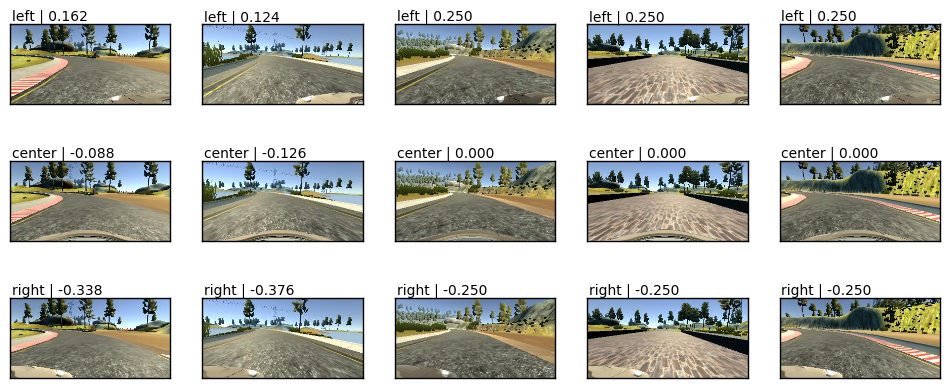

In [27]:
def angle_viewpoint(st_angle, camera_side='center'):
    '''
    steering angle adjustment
    add or subtract constant shift to the steering angle when using left or right camera viewpoint 
    '''
    if camera_side == 'left': return st_angle + 1./4
    if camera_side == 'right': return st_angle - 1./4
    else: return st_angle

n_imgs = 5
ls_imgs = np.random.choice(np.arange(len(log)), size = n_imgs, replace=False)

_, ax = plt.subplots( 3, n_imgs, figsize=(12, 5))
col, row = 0, 0
for i in ls_imgs: 
    
    for k, viewpoint in enumerate(['left', 'center', 'right']):
        img_adress = data_path + log[i, 0].replace('center', viewpoint)
        img = cv2.imread(img_adress)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax[row + k, col].imshow(img)
        new_angle = angle_viewpoint(float(log[i, 3]), viewpoint)
        title_ = viewpoint +' | '+ "{:.3f}".format(new_angle)
        ax[row + k, col].text(3, -8, title_, fontsize=10, color='black')
        ax[row + k, col].get_xaxis().set_ticks([])
        ax[row + k, col].get_yaxis().set_ticks([])

    col = col + 1
plt.show()

## 3. Variation of brightness

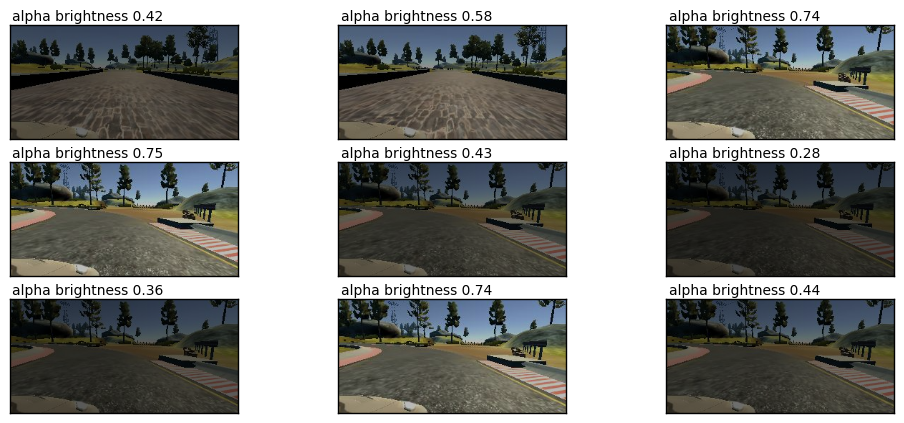

In [8]:
n_imgs = 1
ls_imgs = np.random.choice(np.arange(len(log)), size = n_imgs, replace=False)

_, ax = plt.subplots( 3, 3, figsize=(12, 5))
col, row = 0, 0
for i in range(9): 
    img_adress = data_path + log[i, 0].replace('center', viewpoint)
    img = cv2.imread(img_adress)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    alpha = np.random.uniform(low=0.1, high=1.0, size=None)
    v = hsv[:,:,2]
    v = v * alpha
    hsv[:,:,2] = v.astype('uint8')
    rgb = cv2.cvtColor(hsv.astype('uint8'), cv2.COLOR_HSV2RGB)
    ax[row, col].imshow(rgb)
    title_ = 'alpha brightness {:.2f}'.format(alpha)
    ax[row, col].text(3, -8, title_, fontsize=10, color='black')
    ax[row, col].get_xaxis().set_ticks([])
    ax[row, col].get_yaxis().set_ticks([])
    if col==2:
        row = row + 1
        col = 0
    else:
        col = col + 1
plt.show()

## Steering angle distribution after data augmentation
The steering angle of each example used during training, is recorded in 'y_bag.npy'

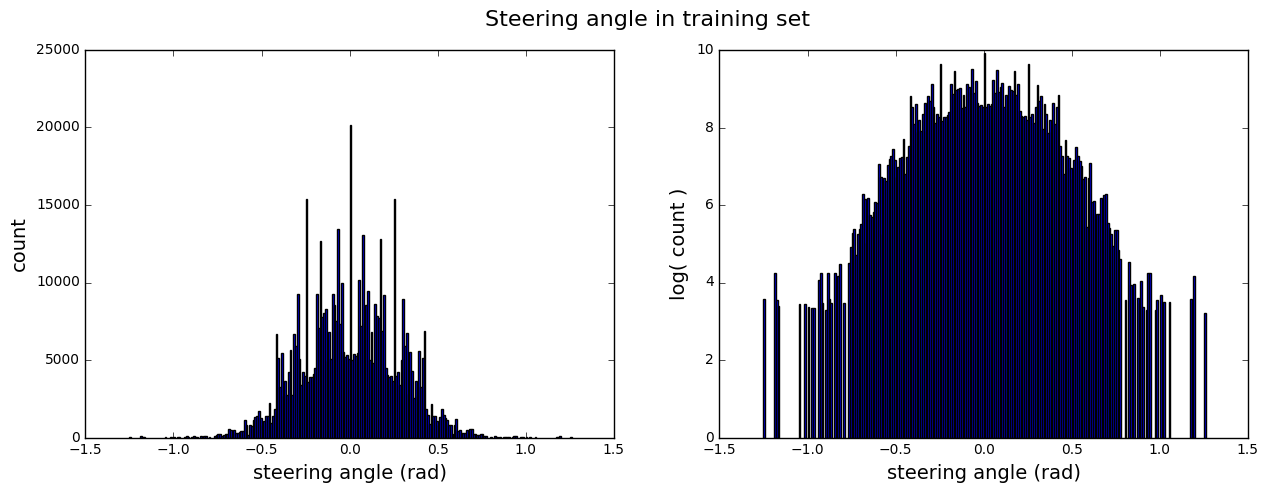

Count of positive angles: 289953 | Negative angles: 290492


In [26]:
y_train = np.load('y_bag.npy')


precision = 0.01
steering_angle = y_train * 1/precision #convert steering to degrees
steering_angle = steering_angle.astype(int) * precision

# Histogram of steering angle values
hist = []
for i in np.unique(steering_angle) :
    count = np.sum( steering_angle == i )
    hist.append([i, count])

hist = np.array(hist)
#plot histogram

_, ax = plt.subplots( 1, 2, figsize=(15, 5) )
plt.suptitle('Steering angle in training set', fontsize=16)
ax[0].bar(hist[:,0], hist[:,1], width=0.01, color='b')
ax[0].set_xlabel('steering angle (rad)', fontsize=14)
ax[0].set_ylabel('count', fontsize=14)


ax[1].bar(hist[:,0], np.log( hist[:,1] ), width=0.01, color='b')
plt.xlabel('steering angle (rad)', fontsize=14)
plt.ylabel('log( count )', fontsize=14)

plt.show()

cnt_neg = np.sum(steering_angle < 0)
cnt_pos = np.sum(steering_angle > 0)
print('Count of positive angles: {} | Negative angles: {}'.format(cnt_pos, cnt_neg))

## Steering angle prediction

### Data augmentation features

In [10]:
def horizontal_flip(img, label):
    '''
    Randomly flip image along horizontal axis: 1/2 chance that the image will be flipped
    img: original image in array type
    label: steering angle value of the original image
    '''
    choice = np.random.choice([0,1])
    if choice == 1:
        img, label = cv2.flip(img, 1), -label
    
    return (img, label)


def transf_brightness(img, label):
    '''
    Adjust the brightness of the image, by a randomly generated factor between 0.1 (dark) and 1. (unchanged)
    img: original image in array type
    label: steering angle value of the original image
    '''
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #change Value/Brightness/Luminance: alpha * V
    alpha = np.random.uniform(low=0.1, high=1.0, size=None)
    v = hsv[:,:,2]
    v = v * alpha
    hsv[:,:,2] = v.astype('uint8')
    #min_val = np.min(hsv[:,:,2])
    #max_val = np.max(hsv[:,:,2])
    #print('min:{} | max: {}'.format(min_val, max_val))
    rgb = cv2.cvtColor(hsv.astype('uint8'), cv2.COLOR_HSV2RGB)
    
    return (rgb, label)


def center_RightLeft_swap(img_adress, label, label_corr = 1/4):
    '''
    With equal probability, change the camera view point to left, right or center.
    Add a correction to the original steering angle value
    return the new image and corresponding corrected steering angle
    img_adres: physical location of the original image file
    label: steering angle value of the original image
    label_corr: correction of the steering angle to be applied. default value= 1.5/10
    Assume distance center-to-left or center-to-right is 1.5m, 
    and that the car recovers from the track error within 10m
    '''
    swap = np.random.choice(['L', 'R', 'C'])

    if swap == 'L':
        img_adress = img_adress.replace('center', 'left')
        corrected_label = label + label_corr
        return (img_adress, corrected_label)
    
    elif swap == 'R':
        img_adress = img_adress.replace('center', 'right')
        corrected_label = label - label_corr
        return (img_adress, corrected_label)
    
    else:
        return (img_adress, label)

    
def filter_zero_steering(label, del_rate):
    '''
    Randomly pick examples with steering angle of 0, and return their index
    label: list of steering angle value in the original dataset
    del_rate: rate of deletion - del_rate=0.9 means delete 90% of the example with steering angle=0
    '''
    steering_zero_idx = np.where(label == 0)
    steering_zero_idx = steering_zero_idx[0]
    size_del = int( len(steering_zero_idx) * del_rate )
    
    return np.random.choice(steering_zero_idx, size=size_del, replace=False)


def image_transformation(img_adress, label, data_dir):
    # Image swap at random: left-right-center
    img_adress, label = center_RightLeft_swap(img_adress, label )
    # Read img file and convert to RGB
    img = cv2.imread(data_dir + img_adress)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # change luminance: 50% chance
    img, label = transf_brightness(img, label)
    #flip image: 50% chance
    img, label = horizontal_flip(img, label)

    return (img, label)

### Model


In [11]:
def continuousSteering(img_sz, activation_fn = 'relu', l2_reg=[10**-3, 10**-3]):
    # size of pooling area for max pooling
    pool_size = (2, 2)
    print(img_sz)
    model = Sequential()
    #model.add(Lambda(lambda x: x/255.-0.5,input_shape=img_sz))

    #dropout = 0.95
    model.add(Convolution2D(8, 5, 5, subsample=(1, 1), border_mode="valid", name='conv1', input_shape=img_sz, \
                           W_regularizer=l2(l2_reg[1])))
    if activation_fn == 'elu':
        model.add(Activation('elu'))
    elif activation_fn == 'prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    #model.add(ZeroPadding2D((1, 1)))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Convolution2D(8, 5, 5, subsample=(1, 1), border_mode="valid", W_regularizer=l2(l2_reg[1])) )
    if activation_fn == 'elu':
        model.add(Activation('elu'))
    elif activation_fn == 'prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))
    
    model.add(Convolution2D(16, 4, 4, subsample=(1, 1), border_mode="valid", W_regularizer=l2(l2_reg[1])) )
    if activation_fn == 'elu':
        model.add(Activation('elu'))
    elif activation_fn == 'prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=pool_size))

    model.add(Convolution2D(16, 5, 5, subsample=(1, 1), border_mode="valid", W_regularizer=l2(l2_reg[1]),))
    if activation_fn == 'elu':
        model.add(Activation('elu'))
    elif activation_fn == 'prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))

    model.add(Flatten())
    
    model.add(Dense(128, W_regularizer=l2(l2_reg[0])))
    if activation_fn == 'elu':
        model.add(Activation('elu'))
    elif activation_fn == 'prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    #model.add(Dropout(dropout))
    
    model.add(Dense(50, W_regularizer=l2(l2_reg[0])))
    if activation_fn == 'elu':
        model.add(Activation('elu'))
    elif activation_fn == 'prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    #model.add(Dropout(dropout))
    
    model.add(Dense(10, W_regularizer=l2(l2_reg[0])))
    if activation_fn == 'elu':
        model.add(Activation('elu'))
    elif activation_fn == 'prelu':
        model.add(PReLU())
    else:
        model.add(Activation('relu'))
    #model.add(Dropout(dropout))
    
    model.add(Dense(1, activation='linear', W_regularizer=l2(l2_reg[0]), init='he_normal'))
   # optimizer = 
    adam = Adam(lr=0.001)
    model.compile(optimizer=adam, loss='mean_squared_error')

    print('Lightweight Model is created and compiled..- activation: {}'.format(activation_fn))
    return model

In [12]:
def batch_generator(x, y, batch_size, img_sz,
                    training=True, 
                    del_rate=0.95, 
                    data_dir='data/', 
                    monitor=True,
                   yieldXY=True):
    """
    Generate training batch: Yield X and Y data when the batch is filled.
    Data augmentation schemes: horizontal flip, chnage brightness, change viewpoint
    At each EPOCH, before data augmentation, del_rate=95% of examples with 
    steering angle = 0 are deleted from original dataset
    x: list of the adress of all images to be used for training
    y: steering angles
    training: use True for generating training batch with data augmentation scheme 
              use False to generate validation batch
    batch_size: size of the batch (X, Y)
    img_sz: size of the image (height, width, channel) to generate
    del_rate: percent of examples with steering angle=0 that will be deleted before generating batches
    data_dir: adress to the directory IMG/*.jpg
    monitor: save X of the last batch generated 'X_batch_sample.npy
             save angles of all batches generated 'y_bag.npy
    yieldXY: if True, generator yields (X, Y)
            otherwise, yields X only (useful for predict_generator()
    """
    
    if training:
        y_bag = []
        x, y = shuffle(x, y)
        rand_zero_idx = filter_zero_steering(y, del_rate=del_rate)
        new_x = np.delete(x, rand_zero_idx, axis=0)
        new_y = np.delete(y, rand_zero_idx, axis=0)
        new_x = x
        new_y = y
    else:
        new_x = x
        new_y = y
    offset = 0
    '''
    True as long as total number of examples generated is lower than the number of 'samples_per_epoch' set by user.
    '''
    while True: 
        # Initialize X and Y array
        X = np.empty((batch_size, *img_sz))
        Y = np.empty((batch_size, 1))
        #Generate a batch
        for example in range(batch_size):
            img_adress, img_steering = new_x[example + offset], new_y[example + offset]
            assert os.path.exists(data_dir + img_adress), 'Image file ['+ img_adress +'] not found-'
            
            if training:
                img, img_steering = image_transformation(img_adress, img_steering, data_dir)
            else:
                img = cv2.imread(data_dir + img_adress)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # crop / resize image / scale pixel intensity
            # update batch X and Y array with new example
            X[example,:,:,:] = cv2.resize(img[80:140, 0:320], (img_sz[0], img_sz[1]) ) / 255. - 0.5
            
            Y[example] = img_steering
            if training:
                y_bag.append(img_steering)
            
            '''
             when reaching end of original dataset x, loop from start again
             shuffle original dataset / randomly remove 95% of the example with steering angle = 0
             
            '''
            if (example + 1) + offset > len(new_y) - 1:
                x, y = shuffle(x, y)
                rand_zero_idx = filter_zero_steering(y, del_rate=del_rate)
                new_x = x
                new_y = y
                new_x = np.delete(new_x, rand_zero_idx, axis=0)
                new_y = np.delete(new_y, rand_zero_idx, axis=0)
                offset = 0
        if yieldXY:
            yield (X, Y)
        else:
            yield X

        offset = offset + batch_size
        if training:
            np.save('y_bag.npy', np.array(y_bag) )
            np.save('Xbatch_sample.npy', X ) #save last batch of images

### Parameters

In [13]:
test_size = 0.2
img_sz = (128, 128, 3)
batch_size = 200
data_augmentation = 200
nb_epoch = 15
del_rate = 0.95
activation_fn = 'relu'
l2_reg = [0.00001, 0]
print('Total number of samples per EPOCH: {}'.format(batch_size * data_augmentation))

x_ = log[:, 0] 
y_ = log[:, 3].astype(float)
x_, y_ = shuffle(x_, y_)
# split train/validation set with ratio: 5:1
X_train, X_val, y_train, y_val = train_test_split(x_, y_, test_size=test_size, random_state=SEED)
print('Train set size: {} | Validation set size: {}'.format(len(X_train), len(X_val)))
    
samples_per_epoch = batch_size * data_augmentation 
# make validation set size to be a multiple of batch_size
nb_val_samples = len(y_val) - len(y_val)%batch_size 

Total number of samples per EPOCH: 40000
Train set size: 6428 | Validation set size: 1608


In [14]:
model =  continuousSteering( img_sz, activation_fn = activation_fn, l2_reg=l2_reg)
print(model.summary())

'''
Callbacks: save best and early stop - based on validation loss value
1. Save the model after each epoch if the validation loss improved, or
2. stop training and save model if the validation loss doesn't improve for 5 consecutive epochs.

'''

model_path = os.path.expanduser('model.h5')
save_best = callbacks.ModelCheckpoint(model_path, monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=15, 
                                     verbose=0, mode='auto')
callbacks_list = [early_stop, save_best]

# batch generator default value: 
#training=True, del_rate=0.95, data_dir='data/', monitor=True
history = model.fit_generator(batch_generator(X_train, y_train, batch_size, img_sz, training=True, del_rate=del_rate),
                              samples_per_epoch=samples_per_epoch,
                              nb_val_samples=nb_val_samples,
                              validation_data=batch_generator(X_val, y_val, batch_size, img_sz, 
                                                              training=False, monitor=False),
                              nb_epoch=nb_epoch, verbose=1, callbacks=callbacks_list
                             )
# save model architecture and weights

with open('model.json', 'w') as f:
        f.write( model.to_json() )
model.save('model_.h5')
print('Model saved!')

(128, 128, 3)
Lightweight Model is created and compiled..- activation: relu
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
conv1 (Convolution2D)            (None, 124, 124, 8)   608         convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 124, 124, 8)   0           conv1[0][0]                      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 62, 62, 8)     0           activation_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 58, 58, 8)     1608        maxpooling2d_1[0][0]             
_______________

# Steering angle prediction

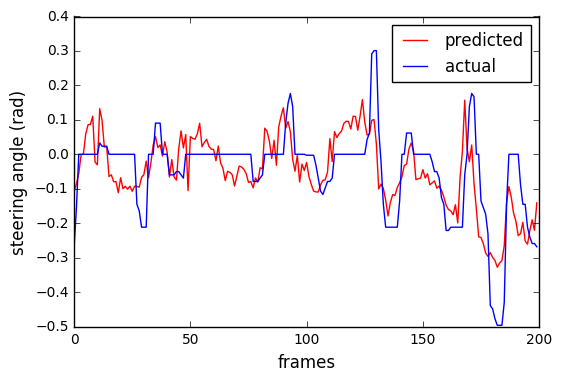

In [24]:
# Select duration in nbr of frames
duration = 200
#select a random start frame.
start_frame = np.random.choice(np.arange(0, len(log)-int(duration), 1) ) 
data4eval = log[start_frame:start_frame+duration, [0, 3]]

steering_pred = []

for img_adress in data4eval[:,0]:
    img = cv2.imread( 'data/'+img_adress)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img[80:140, 0:320]
    img = cv2.resize( img, (128, 128) ) / 255. - 0.5
    transformed_image_array = img[None, :, :, :]
    steering_angle = float(model.predict(transformed_image_array, batch_size=1))
    steering_pred.append(steering_angle)


plt.plot(np.arange(0, int(duration), 1), steering_pred, color='red', label='predicted')
plt.plot(np.arange(0, int(duration), 1), data4eval[:,1], color='blue', label='actual')
plt.xlabel('frames', fontsize=12)
plt.ylabel('steering angle (rad)', fontsize=12)
plt.legend()
plt.show()

## Visualize Images after pre-processing

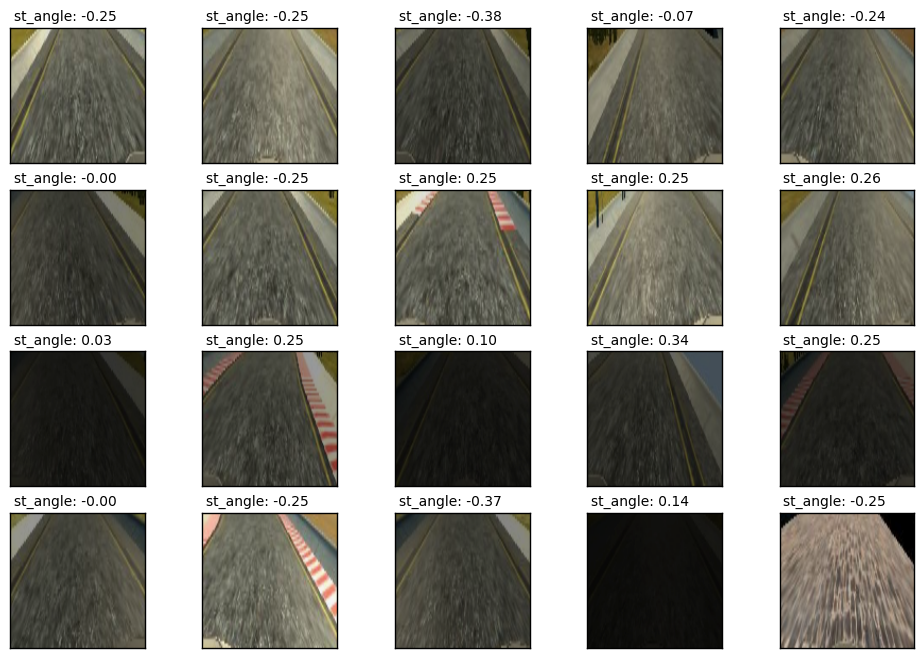

In [16]:
img_check = np.load('Xbatch_sample.npy')
y_check = np.load('y_bag.npy')

n_imgs = 20
ls_imgs = np.random.choice(np.arange(len(img_check)), size = n_imgs, replace=False)

_, ax = plt.subplots( 4, 5, figsize=(12, 8))
col, row = 0, 0
for i in ls_imgs: 
    img = (img_check[i, :,:,:] + 0.5) * 255
    ax[row, col].imshow(img.astype('uint8'))
    title_ = 'st_angle: {:.2f}'.format(y_check[i])
    ax[row, col].text(3, -8, title_, fontsize=10, color='black')
    ax[row, col].get_xaxis().set_ticks([])
    ax[row, col].get_yaxis().set_ticks([])
    if col==4:
        row = row + 1
        col = 0
    else:
        col = col + 1
plt.show()

# Visualize filters:
Select 3 filters of each layer
layer[0]: conv1
layer[3]: conv2
layer[6]: conv3
layer[9]: conv4

Filters shape for the convolutional layers (format = [height, width, depth, nbr]) 
 	 conv1: W(5, 5, 3, 8)
 	 conv2: W(5, 5, 8, 8)
 	 conv3: W(4, 4, 8, 16)
 	 conv4: W(5, 5, 16, 16)


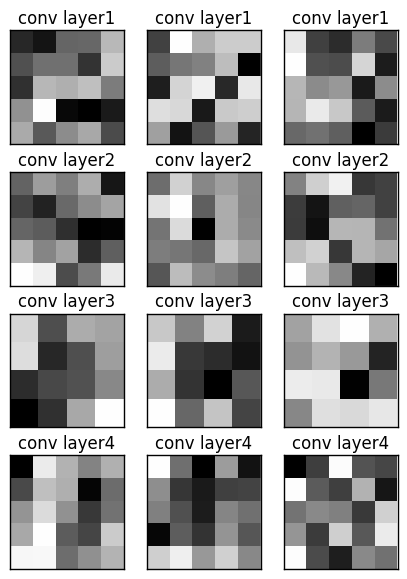

In [17]:
# filters at
_, ax = plt.subplots( 4, 3, figsize=(5,7))
col, row = 0, 0
print('Filters shape for the convolutional layers (format = [height, width, depth, nbr]) ')
for layer_idx in [0, 3, 6, 9]:
    weights = np.array( model.layers[layer_idx].get_weights() )[0]
    convlayer = int(layer_idx/3 +1)
    print(' \t conv{}: W{}'.format(convlayer, weights.shape) )
    for kernel_idx in [0, 1, 2]:
        kernel = weights[:,:, 0, kernel_idx]
        ax[row, col].imshow(kernel, cmap='gray', interpolation='none')
        ax[row, col].get_xaxis().set_ticks([])
        ax[row, col].get_yaxis().set_ticks([])
        ax[row, col].get_yaxis().set_ticks([])
        
        ax[row, col].title.set_text('conv layer'+ str(convlayer))
        col = col + 1
    row = row + 1
    col = 0

plt.show()


# Visualize activations at the convolutional layers

Visualize the activation at the 4 convolution layer using randomly selected input images
Activation of feature map at depth=3

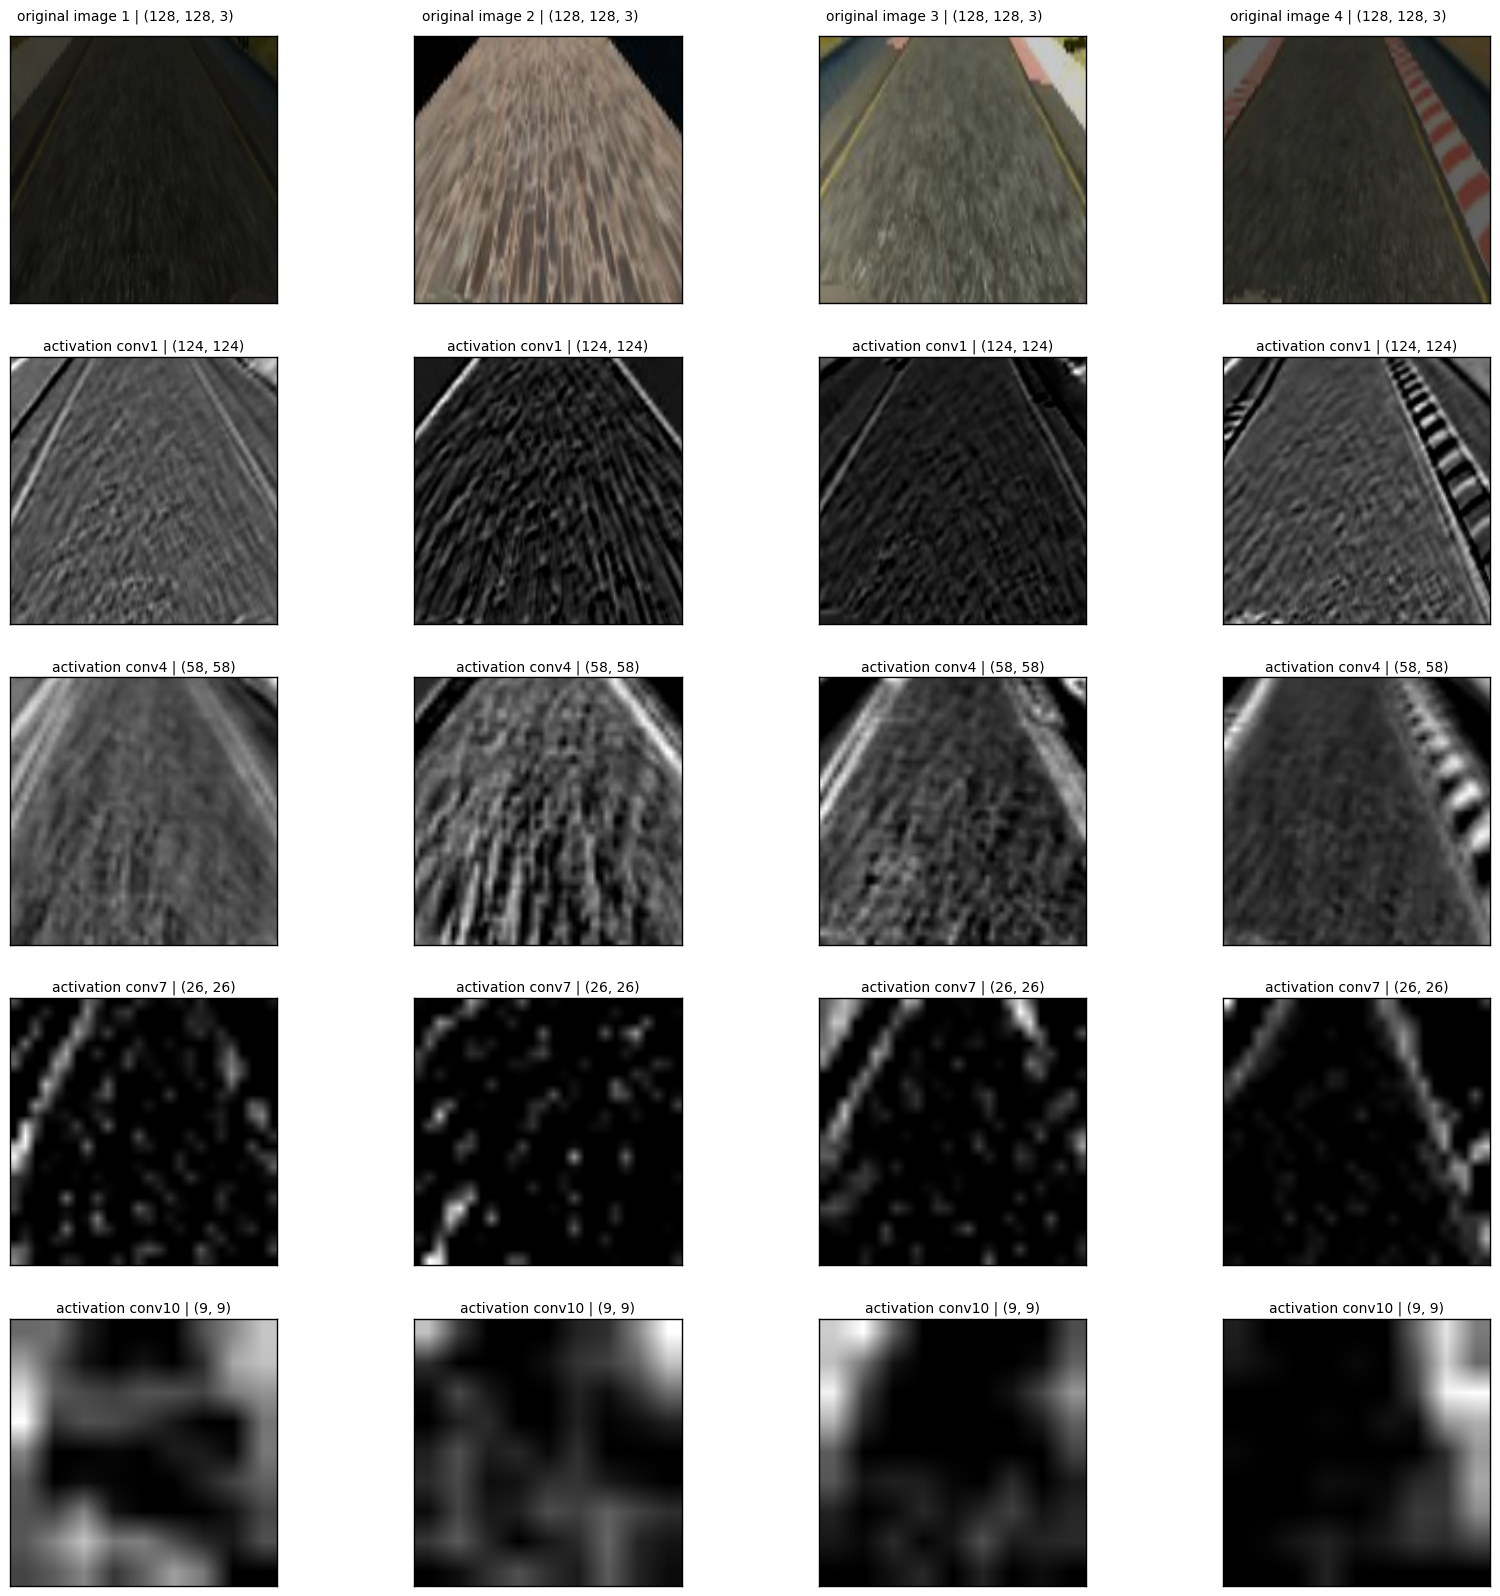

In [18]:
n_imgs = 4

ls_img = np.random.choice(np.arange(len(img_check)), size = n_imgs, replace=False)
_, ax = plt.subplots( 5, 4, figsize=(20,20) )

row, col = 0, 0

for k, img_id in enumerate(ls_img):
    img_input = img_check[img_id, :,:,:]
    img_input = img_input.reshape((1, *img_sz) )
    
    for layer_id in [-1, 1, 4, 7, 10]:
        
        if layer_id == -1: #show input image
            img_4display = (img_input[0] + 0.5) * 255 
            ax[row, col].imshow(img_4display.astype('uint8'))
            title_ = 'original image {} | {}'.format(k + 1, img_4display.shape)
            ax[row, col].text(3, -8, title_, fontsize=10, color='black')
            ax[row, col].get_xaxis().set_ticks([])
            ax[row, col].get_yaxis().set_ticks([])
            row = row + 1

            
        else:
            get_layer_output = K.function([model.layers[0].input], [model.layers[layer_id].output])
            layer_output = get_layer_output([img_input])[0]
            title_ = 'activation conv{} | {}'.format(layer_id, layer_output[0, :,:,0].shape)
            ax[row, col].set_title(title_, fontsize=10, color='black')
            ax[row, col].imshow(layer_output[0,:,:,0], cmap='gray') #display 1st activation map
            ax[row, col].get_xaxis().set_ticks([])
            ax[row, col].get_yaxis().set_ticks([])
            if row == 4:
                row = 0
                col += 1
            else:
                row += 1

# Performance on Track 2

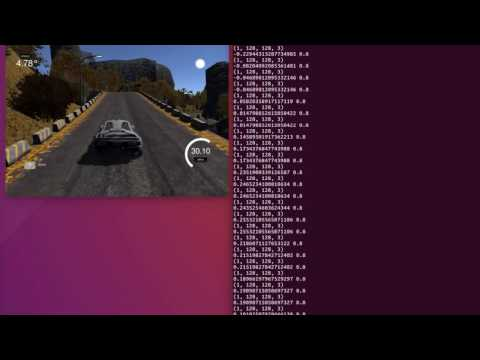

In [19]:
from IPython.display import YouTubeVideo
YouTubeVideo("esVH7HmJVcg")